# Python Workshop 2023 - University of Toledo

#### Author:  Ryan Hazlett

<b>Email:  </b> ryan.hazlett@rockets.utoledo.edu 

***

## Overview

- A quick example of how to use `curve_fit` with your research.
- Easy way to format plots at the beginning of your code.
- Demo for using interactive sliders in Jupyter notebooks.

#### Install Libraries

<div class="alert alert-block alert-info">
<b>First:</b>  Run the function below to install any missing libraries used in this demo if needed. Will not install any libraries you already have.
</div>

In [50]:
def get_missing_libraries(install_method='pip'):
    import sys
    import subprocess
    import pkg_resources

    required = {'scipy'}
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = required - installed
    
    if missing:
        python = sys.executable
        subprocess.check_call([python, '-m', install_method, 'install', *missing], stdout=subprocess.DEVNULL)

Run cell below to install any missing libraries, change install_method to your choice of 'pip' or 'conda'

In [51]:
get_missing_libraries(install_method='pip')

#### Import Libraries

In [52]:
# Quick way to import numpy and matplotlib
%pylab inline

# curve_fit function used for fitting data
from scipy.optimize import curve_fit

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#### Configure Plot Parameters

Can run this beforehand to format plots.

In [53]:
# Default size parameters
figsize = (10,10)
fontsize = 14
TITLE_SIZE = 32
LABEL_SIZE = 24
SMALL_TICK_SIZE = 6
BIG_TICK_SIZE = 12

# Configure plot parameters
plt.rcParams.update({'font.size': fontsize, 
                     'figure.figsize': figsize, 
                     'figure.titlesize': TITLE_SIZE})


# Default tick label size
plt.rcParams['axes.linewidth'] = 2

plt.rcParams['xtick.labelsize'] = LABEL_SIZE
plt.rcParams['ytick.labelsize'] = LABEL_SIZE
plt.rcParams['xtick.major.size'] = BIG_TICK_SIZE
plt.rcParams['ytick.major.size'] = BIG_TICK_SIZE
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = SMALL_TICK_SIZE
plt.rcParams['ytick.minor.size'] = SMALL_TICK_SIZE

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

## Using `scipy.curve_fit` to Analyze your Data

#### Gaussian Function used in Fitting

$$ f(x) = A \ \mathrm{exp} \left( - \frac{(x - \mu)^{2}}{2 \sigma^{2}} \right) $$

In [54]:
def gaussian_func(x,ampl,center,std):
    return ampl * np.exp(-0.5 * (x - center)**2 / std**2)

### Generate Spectrum Composed of Gaussian Components

Don't print anything out from the cell below to keep things a mystery!

In [55]:
# Wavelength Range
lower_wl = 10.
upper_wl = 100.
wave = np.linspace(lower_wl, upper_wl, 500)

# Randomly create between 1-? gaussians
max_num_gauss = 5
np.random.seed(1) # Same seed so everyone gets the same thing
num_gauss = np.random.randint(1, max_num_gauss)

# Make spectrum out of unknown number of gaussians
intensity = 0.
all_ampl = np.zeros(num_gauss)
all_center = np.zeros(num_gauss)
all_std = np.zeros(num_gauss)
for i in range(num_gauss):
    what_kind = np.random.randint(0, 10)
    if what_kind >= 7:
        rand_ampl = np.random.uniform(2,7)
    else:
        rand_ampl = np.random.uniform(-5,-2)
    rand_center = np.random.uniform(lower_wl*1.2,upper_wl*0.8)
    rand_std = np.random.uniform(0.01*(upper_wl-lower_wl),0.6*(upper_wl-lower_wl))
    intensity += gaussian_func(wave,rand_ampl,rand_center,rand_std)
    
    all_ampl[i] = rand_ampl
    all_center[i] = rand_center
    all_std[i] = rand_std

# Add some random noise to data
intensity += np.random.normal(0., 0.2, wave.shape)

print(num_gauss)
print(all_ampl)
print(all_center)
print(all_std)

2
[ 2.00057187 -3.81025782]
[32.55861494 38.3779304 ]
[ 8.6927378  36.46351455]


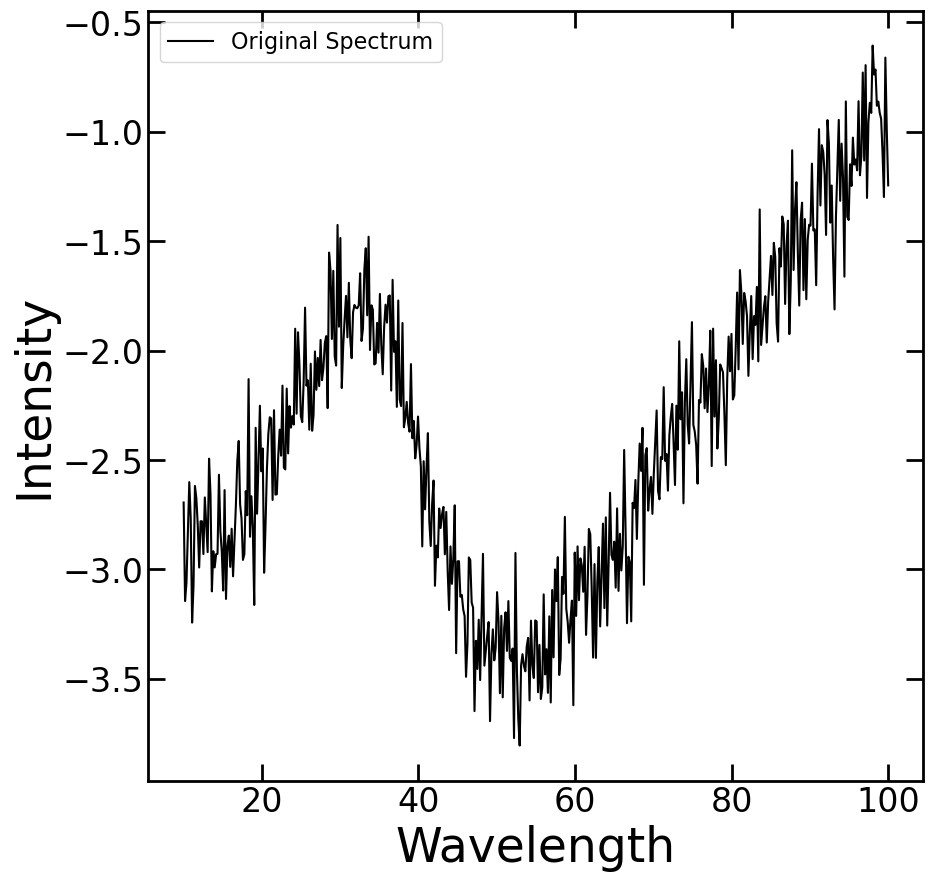

In [56]:
# Plot the original generated spectrum.
plt.clf()
plt.xlabel(r'Wavelength',fontsize=34)
plt.ylabel(r'Intensity',fontsize=34)
plt.plot(wave, intensity, color='black',label="Original Spectrum")
plt.legend(fontsize=16)
plt.show()

#### Now, let's try to figure out the parameters of the gaussians used to make this spectrum!

### Find the Best Fit to your Data using `curve_fit`

Summarizing from (https://www.askpython.com/python/examples/curve-fitting-in-python).

The idea of curve fitting is to look at a dataset and extract optimized values for parameters for a fitting function.

Assume you have dataset $y$ = {$y_{1}$, $y_{2}$, $y_{3}$ …} along with a function $f$ that depends on wavelength $\lambda$ = {$\lambda_{1}$, $\lambda_{2}$, $\lambda_{3}$ …} and some unknown parameters $z$ = {$z_{1}$, $z_{2}$, $z_{3}$ …}. We need to find an optimal value for this unknown parameter $z$ such that the function $y = f(\lambda, z)$ best resembles the function and given datasets. This process is known as curve fitting.

Can apply two different methods to accomplish this:
- Least Square Method (Dataset does not include errors)
- Maximum Likelihood Estimation (Dataset includes errors)

Minimize the following function to find the best fit $z$ parameters (non-linear least squares):

$$ \sum_{i} \frac{\left[ f(\lambda_{i},z) - y_{i} \right]^{2}}{\sigma_{i}^{2}} $$

#### `scipy.optimize.curve_fit` 

Documentation:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

```Python
curve_fit(f, xdata, ydata, p0=None, sigma=None, bounds=(-np.inf, np.inf), method='trf', nan_policy=None, maxfev=10000)
```

Input:
- <b>f:</b> The model function, <i>we will be using a modificied version of the gaussian function we defined earlier.</i>
- <b>xdata:</b> The independent variable, <i>wavelength in our case.</i>
- <b>ydata:</b> The dependent data, <i>intensity of our generated spectrum.</i>
- <b>p0:</b> Initial guess for the parameters, <i>we will need to find these!</i>
- <b>sigma:</b> Determines the uncertainty in ydata, <i>None in this example, with real data you will include.</i>
- <b>bounds:</b> Lower and upper bounds on parameters, <i>we will want to change these!</i>
- <b>method:</b> Method to use for optimization, <i>will typically default to best method, normally don't include.</i>
- <b>nan_policy:</b> Defines how to handle when input contains nan, <i>can change to ‘omit’ to perform the calculations ignoring nan values.</i>
- <b>maxfev:</b> Increases iterations to find best fit, <i>normally not included, can change if curve fit is timing out.</i>

Returns:
- <b>popt:</b> Optimal values for the parameters so the non-linear least squares function is minimized
- <b>pcov:</b> The estimated approximate covariance of popt. The diagonals provide the variance of the parameter estimate.

### Setting things up

If we were fitting a single gaussian, could use the function we defined earlier:

```Python
initial_params = # ?,?,?
my_bounds = # ([min1,min2,min3],[max1,max2,max3])

popt, pcov = curve_fit(f=gaussian_func, xdata=wave, ydata=intensity, p0=initial_params, bounds=my_bounds)
```

### What are Good Initial Parameter Choices and Bounds?

<div class="alert alert-block alert-info">
The function below is used to create an interactive plot with sliders you can use to test initial conditions, you can modify this to use in your own code if it seems helpful.
</div>

In [57]:
def interact_gauss():
    from ipywidgets import interact, FloatSlider
    from IPython.display import display
    
    ## Set up the plot data
    x     = wave # Wavelength data
    fig   = plt.figure()
    plt.plot(wave, intensity, color='black',label=r"Original Spectrum") # This includes the original spectrum in the figure
    line, = plt.plot([], [], color='orangered', linewidth=4, label=r"Test Gaussian") # Initialize curve to empty data.
    
    ## Scale Bar Parameters, Minimum, Maximum, Step Size, and Starting Position
    ampl_min, ampl_max, ampl_step, ampl_init = -10.0, 15.0, 0.1, 0.0
    cent_min, cent_max, cent_step, cent_init = min(wave), max(wave), 0.1, np.mean(wave)
    std_min, std_max, std_step, std_init = 0.1, 100, 0.1, 1.0

    ## Set up the figure axes, etc.
    plt.xlim(0.9*min(wave), 1.05*max(wave)) # Use data to determine bounds
    plt.ylim(0.9*min(intensity), 1.1*max(intensity)) # Use data to determine bounds
    
    plt.xlabel(r'Wavelength',fontsize=34)
    plt.ylabel(r'Intensity',fontsize=34)
    plt.legend(loc="upper left",fontsize=16)
    plt.close()      # Don't show the figure yet.

    ## Callback function
    def plot_gauss(Amplitude,Center,Width):
        y = gaussian_func(x,Amplitude,Center,Width) # Test Gaussian Data
        line.set_data(x, y) # Add Wavelength and Gaussian Data
        display(fig)

    ## Generate the user interface.
    interact(plot_gauss, Amplitude=FloatSlider(min=ampl_min, max=ampl_max, step=ampl_step, value=ampl_init), Center=FloatSlider(min=cent_min, max=cent_max, step=cent_step, value=cent_init), Width=FloatSlider(min=std_min, max=std_max, step=std_step, value=std_init))

#### Find Reasonable Initial Gaussian Parameters

In [58]:
interact_gauss()

interactive(children=(FloatSlider(value=0.0, description='Amplitude', max=15.0, min=-10.0), FloatSlider(value=…

#### Use this to determine your initial parameter and bounds for each gaussian you think is present!

### Define a new model with the number of gaussians you wish to include

```Python
def mult_gauss_model(x,a1,c1,std1,...):
    return a1 * np.exp(-0.5 * (x - c1)**2 / std1**2) + ...
```

Then run `curve_fit`

```Python
initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=mult_gauss_model, xdata=wave, ydata=intensity, p0=initial_params, bounds=my_bounds)
```

### Solution

In [59]:




# I am an empty square trying to convince you to try on your own before scrolling down!














































In [60]:
def mult_gauss_model(x,a1,c1,std1,a2,c2,std2,a3,c3,std3):
    return a1 * np.exp(-0.5 * (x - c1)**2 / std1**2) + a2 * np.exp(-0.5 * (x - c2)**2 / std2**2) + a3 * np.exp(-0.5 * (x - c3)**2 / std3**2)

In [61]:
initial_params = 9.1, 55., 1.6, 5.9, 78.2, 2.4, 3.0, 69.1, 30.1
my_bounds = ([-np.inf,0.,0.01,-np.inf,0.,0.01,-np.inf,0.,0.01], [np.inf,200.,100.,np.inf,200.,100.,np.inf,200.,100.])

popt, pcov = curve_fit(f=mult_gauss_model, xdata=wave, ydata=intensity, p0=initial_params, bounds=my_bounds)

### Gather Fit Values and Get Best Fit Model

In [62]:
fit_ampl = popt[0::3] # Starting on first array index, take every third value
fit_center = popt[1::3] # Starting on second array index, take every third value
fit_std = popt[2::3] # Starting on third array index, take every third value

# Best Fit Model
predict_num_gauss = 3
best_model = 0.
for i in range(predict_num_gauss):
    best_model += gaussian_func(wave,fit_ampl[i],fit_center[i],fit_std[i])

#### Plot Best Fit Model

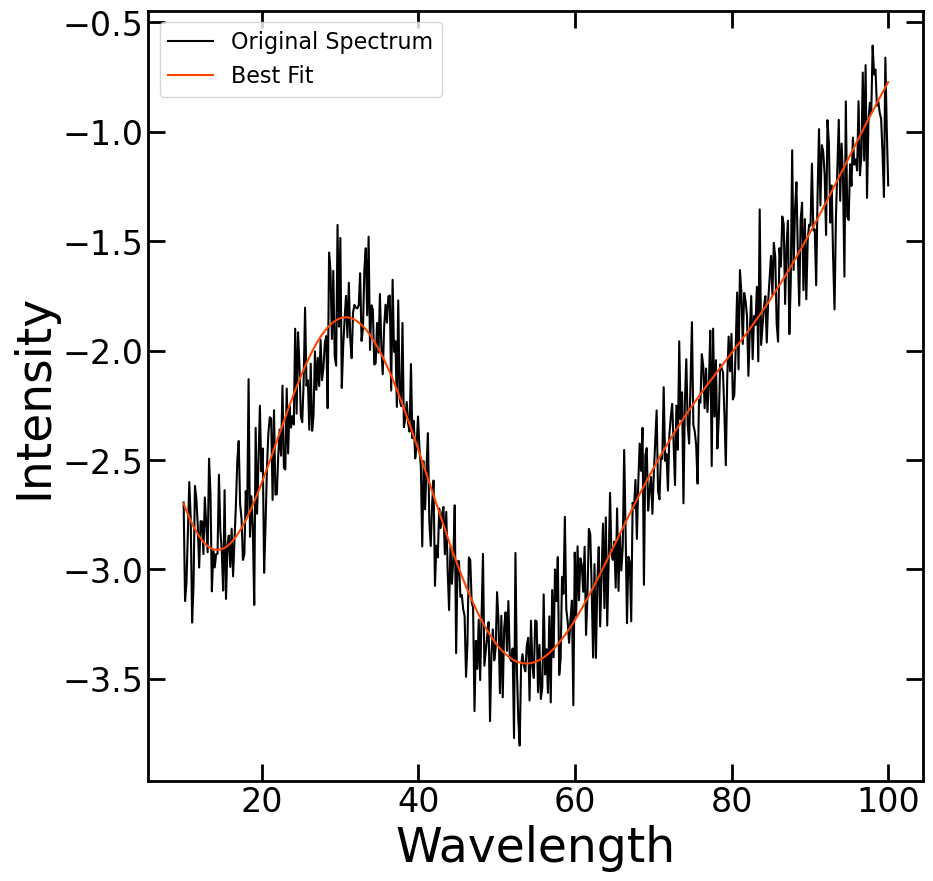

In [63]:
plt.clf()
plt.xlabel(r'Wavelength',fontsize=34)
plt.ylabel(r'Intensity',fontsize=34)
plt.plot(wave, intensity, color='black', label="Original Spectrum")
plt.plot(wave, best_model, color='orangered', label="Best Fit")
plt.legend(fontsize=16)
plt.show()

#### Plot Individual Gaussians

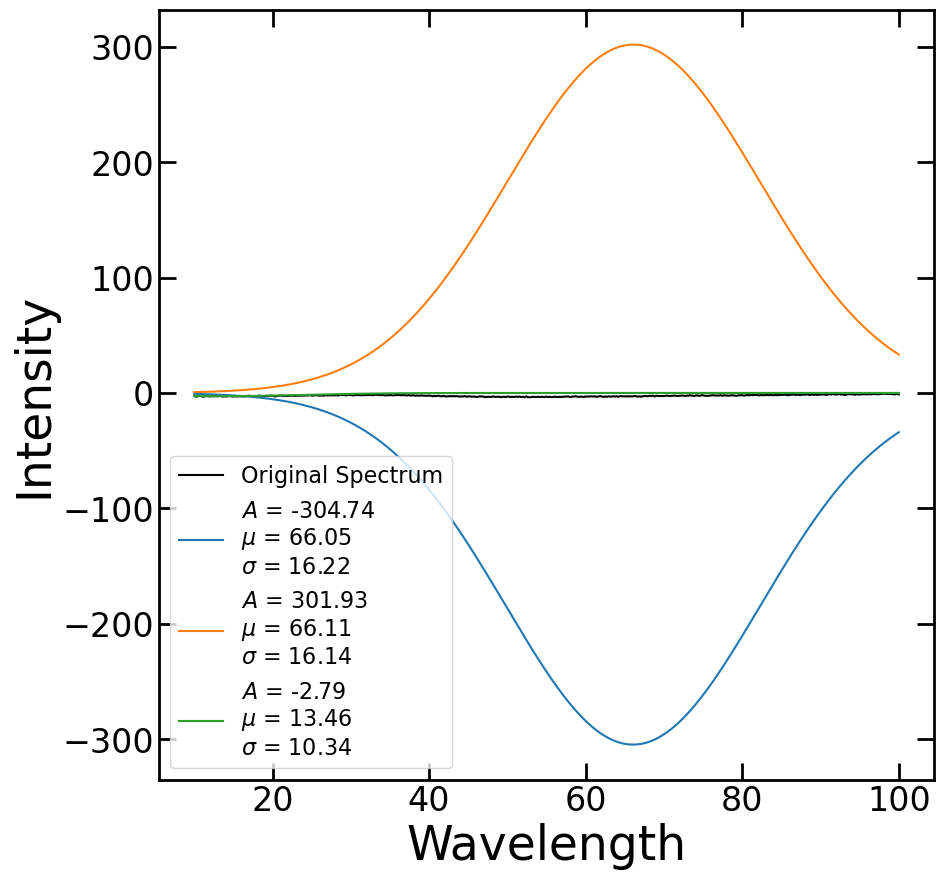

In [64]:
plt.clf()
plt.xlabel(r'Wavelength',fontsize=34)
plt.ylabel(r'Intensity',fontsize=34)
plt.plot(wave, intensity, color='black', label="Original Spectrum")
# Individual Components
for i in range(predict_num_gauss):
    component = gaussian_func(wave,fit_ampl[i],fit_center[i],fit_std[i])
    plt.plot(wave, component, label=r"$A$ = %.2f" "\n" r"$\mu$ = %.2f" "\n" r"$\sigma$ = %.2f"%(fit_ampl[i],fit_center[i],fit_std[i]))
plt.legend(fontsize=16)
plt.show()

### Compare to Exact Generated Values

In [65]:
print("Number of Gaussians:  {:d}".format(num_gauss))
print()
for i in range(num_gauss):
    print("Gaussian {:d}: ".format(i+1))
    print("Amplitude:  {:.4f}".format(all_ampl[i]))
    print("Center:  {:.4f}".format(all_center[i]))
    print("Standard Deviation:  {:.4f}".format(all_std[i]))
    print()

Number of Gaussians:  2

Gaussian 1: 
Amplitude:  2.0006
Center:  32.5586
Standard Deviation:  8.6927

Gaussian 2: 
Amplitude:  -3.8103
Center:  38.3779
Standard Deviation:  36.4635



## You can use any model function you want with `curve_fit`

### Linear Function

$$ g(x) = m x + b $$

```Python
def linear_model(x,m,b):
    return m * x + b

initial_params = # ?,?
my_bounds = # ([min1,min2],[max1,max2])

popt, pcov = curve_fit(f=linear_model, xdata=x, ydata=y, p0=initial_params, bounds=my_bounds)
```

### Sum of Power Laws

$$ g(x) = a x^{b} + c x^{d} + ... + w $$

```Python
def mult_powerlaw_model(x,a,b,c,d,...,w):
    return a * x**b + c * x**d + ... + w

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=mult_powerlaw_model, xdata=x, ydata=y, p0=initial_params, bounds=my_bounds)
```

### Broken Power Laws

- Want one power law to apply to $x$ > 2, the second to apply to 5 < $x$ < 9.

$$ g(x) = a x^{b} + c x^{d} + ... + w $$

```Python
def broken_powerlaw_model(x,a,b,c,d,...,w):
    x1 = x[x > 2]
    x2 = x[np.logical_and(x > 5, x < 9)]
    return a * x1**b + c * x2**d + ... + w

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=broken_powerlaw_model, xdata=x, ydata=y, p0=initial_params, bounds=my_bounds)
```

### Power Laws Including Multiple Data Sets

- Have data that depends on multiple variables x, y, ...

$$ g(x,y,...) = a x^{b} + c y^{d} + ... + w $$

```Python

in_data = dataSet1, dataSet2

def mult_powerlaw_model(in_data,a,b,c,d,...,w):
    x, y = in_data
    return a * x**b + c * y**d + ... + w

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=mult_powerlaw_model, xdata=in_data, ydata=z, p0=initial_params, bounds=my_bounds)
```

### Log-Spaced Power Laws Including Multiple Data Sets

- Have data that depends on multiple variables x, y, ...

$$ log_{\mathrm{10}} g(x,y,...) = a \ log_{\mathrm{10}} x + b \ log_{\mathrm{10}} y + ... + w $$

```Python

in_data = dataSet1, dataSet2

def mult_powerlaw_model(in_data,a,b,c,d,...,w):
    x, y = in_data
    return a*np.log10(x) + b*np.log10(y) + ... + w

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=mult_powerlaw_model, xdata=in_data, ydata=np.log10(z), p0=initial_params, bounds=my_bounds)
```

### Sum of Exponentials

$$ g(x) = a e^{bx} + c e^{dx} + ... + w $$

```Python
def mult_exp_model(x,a,b,c,d,...,w):
    return a * np.exp(b * x) + c * np.exp(d * x) + ... + w

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=mult_exp_model, xdata=x, ydata=y, p0=initial_params, bounds=my_bounds)
```

### Blackbody Continuum with Gaussian Emission/Absorption Lines

$$ g(x) = \frac{2 h c^{2}}{\lambda^{5}} \frac{1}{e^{\frac{h c}{(\lambda k T)}} - 1} + A \ \mathrm{exp} \left( - \frac{(\lambda - \mu)^{2}}{2 \sigma^{2}} \right) + ...$$

```Python
def blackbody_and_lines_model(lam,T,a1,c1,std1,...):
    # Blackbody as a function of wavelength (um) and temperature (K).
    #  returns units of erg/s/cm^2/cm/Steradian
    
    from scipy.constants import h,k,c
    lam = 1e-6 * lam # convert to meters
    return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1)) + a1 * np.exp(-0.5*(x - c1)**2/std1**2) + ...

initial_params = # ?,?,?, ...
my_bounds = # ([min1,...],[max1,...])

popt, pcov = curve_fit(f=blackbody_and_lines_model, xdata=x, ydata=y, p0=initial_params, bounds=my_bounds)
```